In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
import time

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load Data

In [33]:
sales           = pd.read_csv('sales_train.csv.gz')
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
test            = pd.read_csv('test.csv.gz')

# Preparing our data

Since our goal is to predict monthly sales, we need to first set up a dataframe that has the data aggregated by month. The result is a grid which we then merge with aggregated data (sum of item_cnt_day) to form our "all_data" dataframe with our target variable.

In [34]:
# Aggregate data
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
# add missing values accorrding to the distribution of test_data
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
# create grid
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# create target
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

# rename
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]

# merge with items
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

# sort by index cols
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

all_data.head()

/Users/davidaponte/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,shop_id,item_id,date_block_num,target
139255,0,19,0,0.0
141495,0,27,0,0.0
144968,0,28,0,0.0
142661,0,29,0,0.0
138947,0,32,0,6.0


In [35]:
# target distribution
all_data['target'].describe()

count    1.091385e+07
mean     3.342731e-01
std      3.417243e+00
min     -2.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.253000e+03
Name: target, dtype: float64

In [36]:
# clip between 0 and 20
all_data['target'] = all_data['target'].clip(0,20)

all_data['target'].describe()

count    1.091385e+07
mean     2.982399e-01
std      1.222373e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: target, dtype: float64

In [37]:
# shape
all_data.shape

(10913850, 4)

# Feature engineering

In [38]:
# add mean_shop_item_price
index_cols = ['shop_id', 'item_id', 'date_block_num']
# sales df
sales_df = sales[index_cols + ['item_price']].copy()
# create mean_item_shop_price
sales_df['mean_item_shop_price'] = \
    sales_df.groupby(index_cols)['item_price'].transform('mean')
# drop original
sales_df = sales_df.drop('item_price', axis=1).drop_duplicates()
# merge with all_data
all_data = pd.merge(all_data, sales_df, on=index_cols, how='left').fillna(0)
# clear up space
del sales_df

all_data.head()

,shop_id,item_id,date_block_num,target,mean_item_shop_price
0,0,19,0,0.0,0.0
1,0,27,0,0.0,0.0
2,0,28,0,0.0,0.0
3,0,29,0,0.0,0.0
4,0,32,0,6.0,221.0


In [39]:
# add mean_item_price
index_cols = ['item_id', 'date_block_num']
# sales df
sales_df = sales[index_cols + ['item_price']].copy()
# create mean_item_shop_price
sales_df['mean_item_price'] = \
    sales_df.groupby(index_cols)['item_price'].transform('mean')
# drop original
sales_df = sales_df.drop('item_price', axis=1).drop_duplicates()
# merge with all_data
all_data = pd.merge(all_data, sales_df, on=index_cols, how='left').fillna(0)
# clear up space
del sales_df

all_data.head()

,shop_id,item_id,date_block_num,target,mean_item_shop_price,mean_item_price
0,0,19,0,0.0,0.0,28.000000
1,0,27,0,0.0,0.0,2325.000000
2,0,28,0,0.0,0.0,549.000000
3,0,29,0,0.0,0.0,2397.500000
4,0,32,0,6.0,221.0,338.110349


In [40]:
# add std_item_price
index_cols = ['item_id', 'date_block_num']
# sales df
sales_df = sales[index_cols + ['item_price']].copy()
# create mean_item_shop_price
sales_df['std_item_price'] = \
    sales_df.groupby(index_cols)['item_price'].transform('std')
# drop original
sales_df = sales_df.drop('item_price', axis=1).drop_duplicates()
# merge with all_data
all_data = pd.merge(all_data, sales_df, on=index_cols, how='left').fillna(0)
# clear up space
del sales_df

all_data.head()

,shop_id,item_id,date_block_num,target,mean_item_shop_price,mean_item_price,std_item_price
0,0,19,0,0.0,0.0,28.000000,0.000000
1,0,27,0,0.0,0.0,2325.000000,297.161572
2,0,28,0,0.0,0.0,549.000000,0.000000
3,0,29,0,0.0,0.0,2397.500000,248.623209
4,0,32,0,6.0,221.0,338.110349,35.664566


In [41]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()
# merge with all_data
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
# merge with test
test = pd.merge(test, item_category_mapping, how='left', on='item_id')

all_data.head()

,shop_id,item_id,date_block_num,target,mean_item_shop_price,mean_item_price,std_item_price,item_category_id
0,0,19,0,0.0,0.0,28.000000,0.000000,40
1,0,27,0,0.0,0.0,2325.000000,297.161572,19
2,0,28,0,0.0,0.0,549.000000,0.000000,30
3,0,29,0,0.0,0.0,2397.500000,248.623209,23
4,0,32,0,6.0,221.0,338.110349,35.664566,40


In [42]:
test.head()

,ID,shop_id,item_id,item_category_id
0,0,5,5037,19
1,1,5,5320,55
2,2,5,5233,19
3,3,5,5232,23
4,4,5,5268,20


In [43]:
# reduce memory usage
all_data = downcast_dtypes(all_data)
test = downcast_dtypes(test)

In [44]:
# add date_block_num for test
test['date_block_num'] = 34

# Mean Encodings with Regularization

I tried to use this but my computer kept crashing due to a MemoryError. So I decided to use mean encodings without regularization as I got that to work.

In [45]:
"""
def expanding_mean(data,feats_to_encode,target_list):

    
    df_mean_enc=data[['shop_id','item_id','date_block_num']]
    
    for feat in feats_to_encode:
        print ('calculating encoding for ',feat)
        for target in target_list:
            cumsum = data.groupby(feat)[target].cumsum()-data[target]
            cumcnt = data.groupby(feat).cumcount()
            df_mean_enc[target + '_mean_enc_' + feat] = cumsum/(cumcnt+1)


    
    df_mean_enc=downcast_dtypes(df_mean_enc)
    

    print ('df_mean_enc shape is: ', df_mean_enc.shape)


    return df_mean_enc
    """

"\ndef expanding_mean(data,feats_to_encode,target_list):\n\n    \n    df_mean_enc=data[['shop_id','item_id','date_block_num']]\n    \n    for feat in feats_to_encode:\n        print ('calculating encoding for ',feat)\n        for target in target_list:\n            cumsum = data.groupby(feat)[target].cumsum()-data[target]\n            cumcnt = data.groupby(feat).cumcount()\n            df_mean_enc[target + '_mean_enc_' + feat] = cumsum/(cumcnt+1)\n\n\n    \n    df_mean_enc=downcast_dtypes(df_mean_enc)\n    \n\n    print ('df_mean_enc shape is: ', df_mean_enc.shape)\n\n\n    return df_mean_enc\n    "

In [46]:
#mean_encodings = expanding_mean(all_data, ['item_id', 'shop_id', 'item_category_id'], ['target'])
#mean_encodings.head()

In [47]:

#all_data = pd.concat([all_data, mean_encodings.drop(['item_id', 'shop_id', 'date_block_num'], axis=1)], axis=1)

#del mean_encodings

In [48]:
#all_data.head()

# Mean Encodings Without Regularization


In [49]:

# mean encodings using all data without regularization
# item_price

all_data['target_item'] = \
            all_data.groupby(['item_id', 'date_block_num'])['target'].transform('mean')

all_data['target_shop'] = \
            all_data.groupby(['shop_id', 'date_block_num'])['target'].transform('mean')


In [50]:
# target_category
all_data['target_category'] = \
            all_data.groupby(['item_category_id', 'date_block_num'])['target'].transform('mean')
all_data['target_shop_category'] = \
            all_data.groupby(['item_category_id','date_block_num', 'shop_id', ])['target'].transform('mean')

In [51]:
all_data.head()

,shop_id,item_id,date_block_num,target,mean_item_shop_price,mean_item_price,std_item_price,item_category_id,target_item,target_shop,target_category,target_shop_category
0,0,19,0,0.0,0.0,28.000000,0.000000,40,0.022222,0.66679,0.293846,0.739766
1,0,27,0,0.0,0.0,2325.000000,297.161560,19,0.155556,0.66679,0.835177,1.468085
2,0,28,0,0.0,0.0,549.000000,0.000000,30,0.177778,0.66679,1.126854,1.787952
3,0,29,0,0.0,0.0,2397.500000,248.623215,23,0.088889,0.66679,0.547487,1.500000
4,0,32,0,6.0,221.0,338.110352,35.664566,40,5.377778,0.66679,0.293846,0.739766


In [52]:
all_data.shape

(10913850, 12)

In [53]:
# add month
all_data['month'] = all_data['date_block_num'] % 12
test['month'] = all_data['date_block_num'] % 12

# Create Lag Features

In [54]:
# creating lag features
shift_range = [1,2,3,5,12]

def target_lag(train_data, test_data, target_cols, feature_cols):
    # features that will be lagged
    feature_cols += ['date_block_num']
    # iterate through shift range
    for month_shift in shift_range:
        # train
        train_shift = train_data[feature_cols + target_cols].copy().drop_duplicates()
        # shift months
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
        # rename
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in target_cols else x
        
        train_shift = train_shift.rename(columns=foo)
        
        # merge 
        train_data = pd.merge(train_data, train_shift, on=feature_cols, how='left').fillna(0)
        test_data = pd.merge(test_data, train_shift, on=feature_cols, how='left').fillna(0)
    # clear up space    
    del train_shift
    # print new shape
    print(train_data.shape, test.shape)
    return train_data, test_data

In [55]:
# add all kind of lag values
all_data, test = target_lag(all_data, test, ['target'], ['shop_id', 'item_id'])

all_data, test = target_lag(all_data, test, ['target_item'], ['item_id'])

all_data, test = target_lag(all_data, test, ['target_shop'], ['shop_id'])

all_data, test = target_lag(all_data, test, ['target_category'], ['item_category_id'])

all_data, test = target_lag(all_data, test, ['target_shop_category'], ['shop_id', 'item_category_id'])

all_data, test = target_lag(all_data, test, ['mean_item_price'], ['item_id'])

all_data, test = target_lag(all_data, test, ['mean_item_shop_price'], ['shop_id', 'item_id'])

(10913850, 18) (214200, 6)
(10913850, 23) (214200, 11)
(10913850, 28) (214200, 16)
(10913850, 33) (214200, 21)
(10913850, 38) (214200, 26)
(10913850, 43) (214200, 31)
(10913850, 48) (214200, 36)


In [56]:
# save to disk
#all_data.to_csv("all_train_data_with_lags.csv")
#test.to_csv("all_test_data_with_lags.csv")

In [64]:
all_data.head()

,shop_id,item_id,date_block_num,target,mean_item_shop_price,mean_item_price,std_item_price,item_category_id,target_item,target_shop,...,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_5,mean_item_price_lag_12,mean_item_shop_price_lag_1,mean_item_shop_price_lag_2,mean_item_shop_price_lag_3,mean_item_shop_price_lag_5,mean_item_shop_price_lag_12
4488756,2,27,12,0.0,0.0,998.000000,0.000000,19,0.021739,0.114289,...,1048.000000,1198.000000,942.266663,1198.000000,2325.000000,0.0,0.0,0.0,0.0,2499.0
4488757,2,30,12,0.0,0.0,169.000000,0.000000,40,1.260870,0.114289,...,167.256668,165.217392,205.524994,384.894745,0.000000,0.0,0.0,0.0,0.0,0.0
4488758,2,31,12,0.0,0.0,499.000000,0.000000,37,0.326087,0.114289,...,499.000000,488.377777,543.528015,688.400024,0.000000,0.0,0.0,0.0,0.0,0.0
4488759,2,32,12,1.0,119.0,144.710526,16.894035,40,1.826087,0.114289,...,147.994446,144.316452,184.592590,340.172729,338.110352,0.0,0.0,0.0,0.0,0.0
4488760,2,33,12,1.0,199.0,197.487808,9.682774,37,0.913043,0.114289,...,195.899994,194.866669,195.915146,197.277771,488.517242,199.0,199.0,0.0,0.0,499.0


In [65]:
test.head()

,ID,shop_id,item_id,item_category_id,date_block_num,month,target_lag_1,target_lag_2,target_lag_3,target_lag_5,...,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_5,mean_item_price_lag_12,mean_item_shop_price_lag_1,mean_item_shop_price_lag_2,mean_item_shop_price_lag_3,mean_item_shop_price_lag_5,mean_item_shop_price_lag_12
0,0,5,5037,19,34,0,0.0,1.0,3.0,1.0,...,1499.00000,941.385193,894.589844,1342.858276,2569.619873,0.0,749.5,999.166687,1499.0,2599.0
1,1,5,5320,55,34,0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,2,5,5233,19,34,0,1.0,3.0,1.0,2.0,...,1199.00000,711.705750,712.152344,650.931580,0.000000,1199.0,999.0,599.000000,599.0,0.0
3,3,5,5232,23,34,0,0.0,0.0,1.0,0.0,...,1190.43335,703.489136,642.466309,0.000000,0.000000,0.0,0.0,599.000000,0.0,0.0
4,4,5,5268,20,34,0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


# Validation

In [58]:
# only months 12 and above (2014 and after)
all_data = all_data[all_data['date_block_num'] >= 12]

# dates
dates = all_data['date_block_num']
last_block = 33

# train is 12-32
train_data = all_data.loc[dates <  last_block].copy()
# test is 33
val_data = all_data.loc[dates == last_block].copy()

# drop all target features
to_drop_cols = ['ID', 
                'mean_item_price', 
                'mean_item_shop_price', 
                'std_item_price',
                'target', 
                'target_item', 
                'target_shop', 
                'target_item_shop',
                'target_category', 
                'target_shop_category',
                'date_block_num']

to_drop_cols = set(to_drop_cols).intersection(set(train_data.columns))
# X_train, X_val
X_train = train_data.drop(to_drop_cols, axis=1)
X_val =  val_data.drop(to_drop_cols, axis=1)
# y_train, y_val
y_train = train_data['target'].values
y_val =  val_data['target'].values

In [59]:
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(6186922, 39) (238172, 39)
(6186922,) (238172,)


In [60]:
X_train.head()

,shop_id,item_id,item_category_id,month,target_lag_1,target_lag_2,target_lag_3,target_lag_5,target_lag_12,target_item_lag_1,...,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_5,mean_item_price_lag_12,mean_item_shop_price_lag_1,mean_item_shop_price_lag_2,mean_item_shop_price_lag_3,mean_item_shop_price_lag_5,mean_item_shop_price_lag_12
4488756,2,27,19,0,0.0,0.0,0.0,0.0,1.0,0.086957,...,1048.000000,1198.000000,942.266663,1198.000000,2325.000000,0.0,0.0,0.0,0.0,2499.0
4488757,2,30,40,0,0.0,0.0,0.0,0.0,0.0,1.021739,...,167.256668,165.217392,205.524994,384.894745,0.000000,0.0,0.0,0.0,0.0,0.0
4488758,2,31,37,0,0.0,0.0,0.0,0.0,0.0,0.543478,...,499.000000,488.377777,543.528015,688.400024,0.000000,0.0,0.0,0.0,0.0,0.0
4488759,2,32,40,0,0.0,0.0,0.0,0.0,0.0,1.934783,...,147.994446,144.316452,184.592590,340.172729,338.110352,0.0,0.0,0.0,0.0,0.0
4488760,2,33,37,0,1.0,2.0,0.0,0.0,1.0,0.913043,...,195.899994,194.866669,195.915146,197.277771,488.517242,199.0,199.0,0.0,0.0,499.0


In [61]:
test.head()

,ID,shop_id,item_id,item_category_id,date_block_num,month,target_lag_1,target_lag_2,target_lag_3,target_lag_5,...,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_5,mean_item_price_lag_12,mean_item_shop_price_lag_1,mean_item_shop_price_lag_2,mean_item_shop_price_lag_3,mean_item_shop_price_lag_5,mean_item_shop_price_lag_12
0,0,5,5037,19,34,0,0.0,1.0,3.0,1.0,...,1499.00000,941.385193,894.589844,1342.858276,2569.619873,0.0,749.5,999.166687,1499.0,2599.0
1,1,5,5320,55,34,0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,2,5,5233,19,34,0,1.0,3.0,1.0,2.0,...,1199.00000,711.705750,712.152344,650.931580,0.000000,1199.0,999.0,599.000000,599.0,0.0
3,3,5,5232,23,34,0,0.0,0.0,1.0,0.0,...,1190.43335,703.489136,642.466309,0.000000,0.000000,0.0,0.0,599.000000,0.0,0.0
4,4,5,5268,20,34,0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [62]:
to_drop_cols2 = [ 
                'mean_item_price', 
                'mean_item_shop_price', 
                'std_item_price',
                'target', 
                'target_item', 
                'target_shop', 
                'target_item_shop',
                'target_category', 
                'target_shop_category',
                'date_block_num']

to_drop_cols2 = set(to_drop_cols2).intersection(set(test.columns))

X_test = test.drop(to_drop_cols2, axis=1)

In [67]:
X_test.head()

,ID,shop_id,item_id,item_category_id,month,target_lag_1,target_lag_2,target_lag_3,target_lag_5,target_lag_12,...,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_5,mean_item_price_lag_12,mean_item_shop_price_lag_1,mean_item_shop_price_lag_2,mean_item_shop_price_lag_3,mean_item_shop_price_lag_5,mean_item_shop_price_lag_12
0,0,5,5037,19,0,0.0,1.0,3.0,1.0,1.0,...,1499.00000,941.385193,894.589844,1342.858276,2569.619873,0.0,749.5,999.166687,1499.0,2599.0
1,1,5,5320,55,0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,2,5,5233,19,0,1.0,3.0,1.0,2.0,0.0,...,1199.00000,711.705750,712.152344,650.931580,0.000000,1199.0,999.0,599.000000,599.0,0.0
3,3,5,5232,23,0,0.0,0.0,1.0,0.0,0.0,...,1190.43335,703.489136,642.466309,0.000000,0.000000,0.0,0.0,599.000000,0.0,0.0
4,4,5,5268,20,0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


In [69]:
X_test = X_test.drop('ID', axis=1)
X_test.head()

,shop_id,item_id,item_category_id,month,target_lag_1,target_lag_2,target_lag_3,target_lag_5,target_lag_12,target_item_lag_1,...,mean_item_price_lag_1,mean_item_price_lag_2,mean_item_price_lag_3,mean_item_price_lag_5,mean_item_price_lag_12,mean_item_shop_price_lag_1,mean_item_shop_price_lag_2,mean_item_shop_price_lag_3,mean_item_shop_price_lag_5,mean_item_shop_price_lag_12
0,5,5037,19,0,0.0,1.0,3.0,1.0,1.0,0.568182,...,1499.00000,941.385193,894.589844,1342.858276,2569.619873,0.0,749.5,999.166687,1499.0,2599.0
1,5,5320,55,0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,5,5233,19,0,1.0,3.0,1.0,2.0,0.0,0.954545,...,1199.00000,711.705750,712.152344,650.931580,0.000000,1199.0,999.0,599.000000,599.0,0.0
3,5,5232,23,0,0.0,0.0,1.0,0.0,0.0,0.636364,...,1190.43335,703.489136,642.466309,0.000000,0.000000,0.0,0.0,599.000000,0.0,0.0
4,5,5268,20,0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0


# Modeling

In [70]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

In [71]:
import time

params={
    'colsample_bytree': 0.85, 
    'eval_metric': 'rmse', 
    'gamma': 0.6, 
    'learning_rate': 0.03, 
    'max_leaf_nodes': 113, 
    'min_child_weight': 122, 
    'objective': 'reg:linear', 
    'seed': 123, 
    'subsample': 0.75, 
    'tree_method': 'hist'}

watchlist = [(dtrain, 'train'), (dval, 'valid')]

print('Start training')

start=time.time()

model = xgb.train(params, 
                  dtrain, 
                  350,
                  watchlist,
                  early_stopping_rounds=100)

elapsed=time.time()-start
print(elapsed)

Start training
[11:14:23] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[11:15:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-rmse:1.19133	valid-rmse:1.14967
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[11:15:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[1]	train-rmse:1.1776	valid-rmse:1.13904
[11:15:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2]	train-rmse:1.16338	valid-rmse:1.12795
[11:15:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[3]	train-rmse:1.14976	valid-rmse:1.11765
[11:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[4]	train

[50]	train-rmse:0.893436	valid-rmse:0.930378
[11:21:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[51]	train-rmse:0.891751	valid-rmse:0.929228
[11:21:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[52]	train-rmse:0.890097	valid-rmse:0.928237
[11:21:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[53]	train-rmse:0.888562	valid-rmse:0.927142
[11:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[54]	train-rmse:0.887218	valid-rmse:0.926277
[11:21:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[55]	train-rmse:0.885815	valid-rmse:0.925483
[11:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[56]	train-rmse:0.88447	valid-rmse:0.924111
[11:22:0

[102]	train-rmse:0.852329	valid-rmse:0.906399
[11:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[103]	train-rmse:0.85193	valid-rmse:0.906212
[11:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[104]	train-rmse:0.851584	valid-rmse:0.906045
[11:27:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[105]	train-rmse:0.851216	valid-rmse:0.905883
[11:27:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[106]	train-rmse:0.850899	valid-rmse:0.905812
[11:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[107]	train-rmse:0.850573	valid-rmse:0.905711
[11:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[108]	train-rmse:0.85013	valid-rmse:0.905449
[1

[154]	train-rmse:0.838429	valid-rmse:0.901684
[11:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[155]	train-rmse:0.838283	valid-rmse:0.901603
[11:33:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[156]	train-rmse:0.838009	valid-rmse:0.901375
[11:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[157]	train-rmse:0.837785	valid-rmse:0.901277
[11:33:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[158]	train-rmse:0.837389	valid-rmse:0.901381
[11:33:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[159]	train-rmse:0.837233	valid-rmse:0.901291
[11:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[160]	train-rmse:0.836963	valid-rmse:0.901029
[

[206]	train-rmse:0.828259	valid-rmse:0.89864
[11:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[207]	train-rmse:0.828068	valid-rmse:0.898682
[11:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[208]	train-rmse:0.82799	valid-rmse:0.898684
[11:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[209]	train-rmse:0.827864	valid-rmse:0.898676
[11:39:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[210]	train-rmse:0.827558	valid-rmse:0.898644
[11:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[211]	train-rmse:0.827361	valid-rmse:0.898676
[11:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[212]	train-rmse:0.827286	valid-rmse:0.898704
[11:40

[258]	train-rmse:0.821645	valid-rmse:0.897897
[11:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[259]	train-rmse:0.821532	valid-rmse:0.898034
[11:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[260]	train-rmse:0.821461	valid-rmse:0.898153
[11:45:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[261]	train-rmse:0.821361	valid-rmse:0.89811
[11:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[262]	train-rmse:0.821188	valid-rmse:0.898059
[11:45:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[263]	train-rmse:0.821128	valid-rmse:0.898
[11:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[264]	train-rmse:0.821068	valid-rmse:0.898217
[11:46:16

[310]	train-rmse:0.816253	valid-rmse:0.898682
[11:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[311]	train-rmse:0.816196	valid-rmse:0.898645
[11:51:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[312]	train-rmse:0.81613	valid-rmse:0.89863
[11:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[313]	train-rmse:0.816039	valid-rmse:0.898642
[11:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[314]	train-rmse:0.815962	valid-rmse:0.898639
[11:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[315]	train-rmse:0.815744	valid-rmse:0.898566
[11:51:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[316]	train-rmse:0.815664	valid-rmse:0.898668
[11:51:

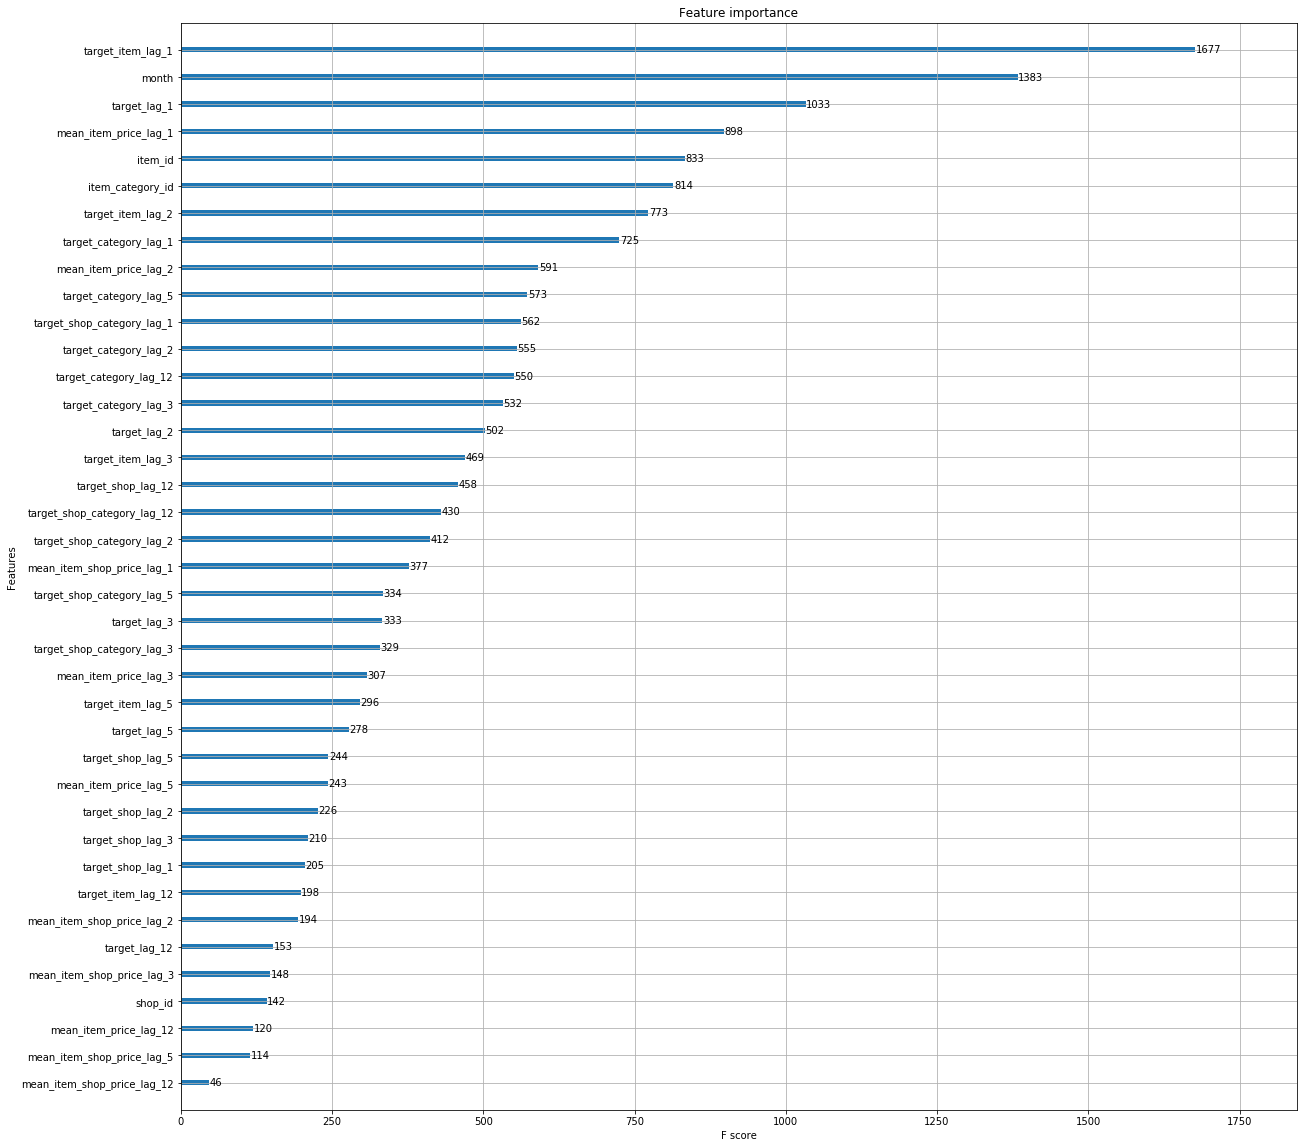

In [72]:
x = xgb.plot_importance(model)
fig = x.figure
fig.set_size_inches(20, 20)
plt.show()

In [75]:
dtest = xgb.DMatrix(X_test)
predictions = model.predict(dtest, ntree_limit=model.best_ntree_limit)

In [76]:
predictions

array([0.47430843, 0.20442793, 0.866876  , ..., 0.03553963, 0.01642796,
       0.02397755], dtype=float32)

In [77]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = predictions
prediction_df.to_csv('predicting_future_sales_submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.474308
1,1,0.204428
2,2,0.866876
3,3,0.363584
4,4,1.890095
5,5,0.404487
6,6,0.566928
7,7,0.166059
8,8,0.899495
9,9,0.619712
